# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
proj_dir = '/content/drive/MyDrive/Colab_Notebooks/Deep_Learning'

import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob(os.path.join(proj_dir, "lfw/*/*")))
dog_files = np.array(glob(os.path.join(proj_dir, "dogImages/*/*/*")))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


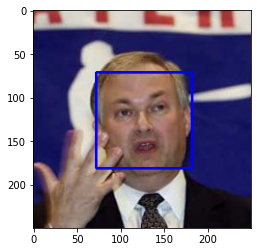

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/project-dog-classification/haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_perf = [0] * len(human_files_short)
for i in range(len(human_files_short)):
    human_perf[i] = face_detector(human_files_short[i])
print('human face ', 1.0*sum(human_perf)/100)  
dog_perf = [0] * len(human_files_short)
for i in range(len(human_files_short)):
    dog_perf[i] = face_detector(dog_files_short[i])
print('dog face ', 1.0*sum(dog_perf)/100) 

human face  0.99
dog face  0.16


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [7]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda:0")
    print("Using",torch.cuda.get_device_name(device))

VGG16 = VGG16.to(device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



CUDA is available!  Training on GPU ...
Using Tesla V100-SXM2-16GB


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [8]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def predict(img_path, model):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = Image.open(img_path)
    # image.show()
    
    loader = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224), 
                                 transforms.ToTensor()])
    image = loader(image).float()
    
    image = image.unsqueeze(0)
    if use_cuda:
        image = image.cuda()
        out = model(image).cpu().data
    else:
        out = model(image).data
    return out.numpy().argmax() # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, model):
    ## TODO: Complete the function.
    pred_index = predict(img_path, model)
    return (pred_index>=151 and pred_index<=268) # true/false
dog_detector("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg", VGG16)

True

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

The VGG16 has the performance below

* 0.0% percentage of the images in human_files_short have a detected dog

* 98.0% percentage of the images in dog_files_short have a detected dog

In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def test_dog_detector(model):
    human_perf = [0] * len(human_files_short)
    for i in range(len(human_files_short)):
        human_perf[i] = dog_detector(human_files_short[i], model)
    print('human face ', 1.0*sum(human_perf)/100)  

    dog_perf = [0] * len(human_files_short)
    for i in range(len(human_files_short)):
        dog_perf[i] = dog_detector(dog_files_short[i], model)
    print('dog face ', 1.0*sum(dog_perf)/100) 

test_dog_detector(VGG16)  

human face  0.0
dog face  0.98


Other pre-trained models were evaluated. The VGG16 with batch normalization is the best according to performance on `human_files_short` and `dog_files_short`.



* 0.0% percentage of the images in human_files_short have a detected dog

* 99.0% percentage of the images in dog_files_short have a detected dog

In [11]:
import torch
import torchvision.models as models

# I'm loading some other models to compare them with the VGG16
VGG16_bn = models.vgg16_bn(pretrained=True)
alexnet = models.alexnet(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
resnet152 = models.resnet152(pretrained=True)
inception_v3 = models.inception_v3(pretrained=True)

# All these models will be used in evaluation mode 
model_list = [alexnet.eval(),VGG16_bn.eval(),resnet18.eval(),resnet152.eval(),inception_v3.eval()]
model_names = ["alexnet","VGG16_bn","resnet18","resnet152","inception_v3"]

# check if CUDA is available
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda:0")
    print("Using",torch.cuda.get_device_name(device))
    
for model, name in zip(model_list, model_names):   
    model = model.to(device)
    print(name)
    test_dog_detector(model)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



CUDA is available!  Training on GPU ...
Using Tesla V100-SXM2-16GB
alexnet
human face  0.0
dog face  0.66
VGG16_bn
human face  0.0
dog face  0.99
resnet18
human face  0.0
dog face  0.94
resnet152
human face  0.0
dog face  0.97
inception_v3
human face  0.04
dog face  1.0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [30]:
import os
from torchvision import datasets
from torchvision import transforms
import torch

import random
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_dir = proj_dir + '/dogImages'
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'

def create_data_loader(batch_size=32, num_workers=4, data_dir = proj_dir + '/dogImages', TRAIN = 'train', VAL = 'valid', TEST = 'test'):
    random.seed(1)
    torch.random.manual_seed(1)

    data_transforms = {
        'train': transforms.Compose([    
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], 
                                [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], 
                                [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], 
                                [0.229, 0.224, 0.225])
        ])
    }

    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x), 
            transform=data_transforms[x]
        )
        for x in [TRAIN, VAL, TEST]
    }

    loaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x], batch_size = batch_size,
            shuffle=True, num_workers = num_workers
        )
        for x in [TRAIN, VAL, TEST]
    }
 
    class_names = image_datasets[TRAIN].classes
    n_classes = len(class_names)
    print("Classes: ", n_classes)
    return image_datasets, loaders

image_datasets, loaders_scratch = create_data_loader()
dataset_sizes = {x: len(loaders_scratch[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    


Classes:  133
Loaded 209 images under train
Loaded 27 images under valid
Loaded 27 images under test


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

* Randomly croping images to reduce background contribution and more focus on dogs
* Horizental flipping the image since image is an object should be equally recongnizible as its mirror image.
* Normalize images

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import kaiming_uniform_ 
# define the CNN architecture
class Net1(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self, depth, n_classes):
        super(Net1, self).__init__()
        ## Define layers of a CNN
        # input is (3, 224, 224)
        self.layer_1_conv = nn.Conv2d(3, depth, (3,3), stride=1, padding=1)
        kaiming_uniform_(self.layer_1_conv.weight, nonlinearity='relu') #He initialization
        self.bn1 = nn.BatchNorm2d(depth)
        self.layer_2_conv = nn.Conv2d(depth, depth, (3,3), stride=1, padding=1)
        kaiming_uniform_(self.layer_2_conv.weight, nonlinearity='relu') #He initialization
        self.bn2 = nn.BatchNorm2d(depth)
        
        depth_2 = depth * 2
        self.layer_3_conv = nn.Conv2d(depth, depth_2, (3,3), stride=1, padding=1)
        kaiming_uniform_(self.layer_3_conv.weight, nonlinearity='relu') #He initialization
        self.bn3 = nn.BatchNorm2d(depth_2)
        self.layer_4_conv = nn.Conv2d(depth_2, depth_2, (3,3), stride=1, padding=1)
        kaiming_uniform_(self.layer_4_conv.weight, nonlinearity='relu') #He initialization
        self.bn4 = nn.BatchNorm2d(depth_2)

        depth_3 = depth_2 * 2
        self.layer_5_conv = nn.Conv2d(depth_2, depth_3, (3,3), stride=1, padding=1)
        kaiming_uniform_(self.layer_5_conv.weight, nonlinearity='relu') #He initialization
        self.bn5 = nn.BatchNorm2d(depth_3)
        self.layer_6_conv = nn.Conv2d(depth_3, depth_3, (3,3), stride=1, padding=1)
        kaiming_uniform_(self.layer_6_conv.weight, nonlinearity='relu') #He initialization
        self.bn6 = nn.BatchNorm2d(depth_3)
        
        self.pool = nn.MaxPool2d(2, 2)
        '''
        self.dropout = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, n_classes)
        '''
        self.fc_out = nn.Linear(depth_3, n_classes)
        
    def forward(self, x):
        ## Define forward behavior
        x = self.layer_1_conv(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.layer_2_conv(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.layer_3_conv(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.layer_4_conv(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.layer_5_conv(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.layer_6_conv(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.pool(x)
        '''
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1_bn(self.fc1(self.dropout(x))))
        x = F.relu(self.fc2_bn(self.fc2(self.dropout(x))))
        x = F.relu(self.fc3(self.dropout(x)))
        '''
        x = x.view(x.size(0), x.size(1), -1)
        x = x.max(2)[0]
        x = self.fc_out(x)
        return x



In [14]:
# instantiate the CNN
model_scratch_1 = Net1(32, 133)

In [15]:
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch_1.cuda()
!pip install torchsummary

from torchsummary import summary
summary(model_scratch_1, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
            Conv2d-3         [-1, 32, 224, 224]           9,248
       BatchNorm2d-4         [-1, 32, 224, 224]              64
         MaxPool2d-5         [-1, 32, 112, 112]               0
            Conv2d-6         [-1, 64, 112, 112]          18,496
       BatchNorm2d-7         [-1, 64, 112, 112]             128
            Conv2d-8         [-1, 64, 112, 112]          36,928
       BatchNorm2d-9         [-1, 64, 112, 112]             128
        MaxPool2d-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          73,856
      BatchNorm2d-12          [-1, 128, 56, 56]             256
           Conv2d-13          [-1, 128, 56, 56]         147,584
      BatchNorm2d-14          [-1, 128,

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

Inspired by the VGG16 model, a 16 layers CNN was built including bathc normalization. Fully-connected layers were removed since it has worse performance if adding them 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [16]:

# Now for the learning rate. Explanation below. 
learning_rates = 5e-4 * np.logspace(0,1.5,9)
learning_rate = learning_rates[2]

In [17]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

### select loss function
criterion_scratch_1 = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch_1 = optim.Adam(model_scratch_1.parameters(), lr = learning_rate)

### select scheduler
scheduler_scratch_1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_scratch_1, 'min', verbose = True, factor = 0.5, patience = 7)


device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [18]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import time
import datetime

def train(n_epochs, loaders, model, optimizer, scheduler, criterion, device, save_path, early_stop):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    model.to(device)
    for epoch in range(1, n_epochs+1):
        
        start_time = time.time()
        print('_______________________')
        
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            # if use_cuda:
                # data, target = data.cuda(), target.cuda()
            data, target = data.to(device), target.to(device)
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(data)
            
            # calculate the batch loss
            loss = criterion(outputs, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            # if use_cuda:
                # data, target = data.cuda(), target.cuda()
            data, target = data.to(device), target.to(device)
            ## update the average validation loss
            
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(data)
            
            # calculate the batch loss
            loss = criterion(outputs, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
         
        # calculate average losses and accuracies
        train_loss = train_loss/len(loaders['train'].dataset)
        all_losses['train'].append(train_loss)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        all_losses['valid'].append(valid_loss)

        time_epoch = time.time() - start_time
        
        time_list.append(time_epoch)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime Usage: {}'.format(
            epoch, 
            train_loss,
            valid_loss,
            time_epoch
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            ## created for early stop
            CNT_no_decrease = 0
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss  
        else:
            CNT_no_decrease = CNT_no_decrease + 1
        if scheduler is not None:    
            scheduler.step(valid_loss)
        print(optimizer.param_groups[0]['lr'])
        if CNT_no_decrease >= early_stop:
            print("performance has not improved for {0} epochs, break loop....".format(early_stop))
            break
            
    print(" ")        
    # return trained model
    return model



In [19]:
import matplotlib.pyplot as plt
def plot(all_losses):
    loss_train = all_losses['train']
    loss_val = all_losses['valid']
    epochs = range(1,len(all_losses['train'])+1)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.xlim(1, len(epochs) +1)
    plt.ylim(0, 5)
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

_______________________
Epoch: 1 	Training Loss: 4.996006 	Validation Loss: 4.816454 	Time Usage: 1251.0118193626404
Validation loss decreased (inf --> 4.816454).  Saving model ...
0.0011856868528308275
_______________________
Epoch: 2 	Training Loss: 4.736398 	Validation Loss: 4.698830 	Time Usage: 80.78410649299622
Validation loss decreased (4.816454 --> 4.698830).  Saving model ...
0.0011856868528308275
_______________________
Epoch: 3 	Training Loss: 4.645369 	Validation Loss: 4.583334 	Time Usage: 79.5807511806488
Validation loss decreased (4.698830 --> 4.583334).  Saving model ...
0.0011856868528308275
_______________________
Epoch: 4 	Training Loss: 4.571570 	Validation Loss: 4.557611 	Time Usage: 78.29945778846741
Validation loss decreased (4.583334 --> 4.557611).  Saving model ...
0.0011856868528308275
_______________________
Epoch: 5 	Training Loss: 4.468137 	Validation Loss: 4.434725 	Time Usage: 79.23352885246277
Validation loss decreased (4.557611 --> 4.434725).  Saving mo

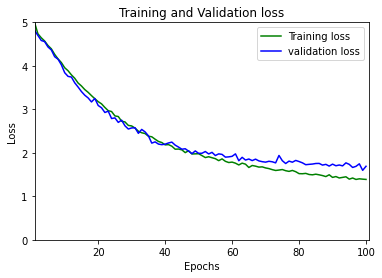

In [20]:
time_list = []
all_losses = {'epoch': [],
              'train': [],
              'valid': []
             }
model_scratch_1 = train(100, loaders_scratch, model_scratch_1, optimizer_scratch_1, scheduler_scratch_1, 
                      criterion_scratch_1, device, 'model_scratch_1.pt', 20)

plot(all_losses)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [21]:
def test(loaders, model, criterion, device):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        # if use_cuda:
            # data, target = data.cuda(), target.cuda()
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [22]:
test(loaders_scratch, model_scratch_1, criterion_scratch_1, device)

Test Loss: 1.794839


Test Accuracy: 52% (439/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [23]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [24]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer_resnet50 = models.resnet50(pretrained=True)

# Freezing all parameters
for param in model_transfer_resnet50.parameters():
    param.requires_grad = False

# Replacing the last layer (by default it will have requires_grad == True)
model_transfer_resnet50.fc = nn.Linear(model_transfer_resnet50.fc.in_features, 133)
# Initialize the weights of the new layer
nn.init.kaiming_normal_(model_transfer_resnet50.fc.weight, nonlinearity='relu')
# Transfer to GPU 
model_transfer_resnet50 = model_transfer_resnet50.to(device)

summary(model_transfer_resnet50, (3,224,224))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

The ResNet50 is selected for transfer learning

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [25]:

criterion_resnet50 = nn.CrossEntropyLoss()
optimizer_resnet50 = optim.Adam(model_transfer_resnet50.parameters(), lr=0.0005)
scheduler_resnet50 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_resnet50, 'min', verbose = True, factor = 0.5, patience = 7)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

_______________________
Epoch: 1 	Training Loss: 3.128471 	Validation Loss: 1.279121 	Time Usage: 81.49829149246216
Validation loss decreased (inf --> 1.279121).  Saving model ...
0.0005
_______________________
Epoch: 2 	Training Loss: 1.506847 	Validation Loss: 0.783883 	Time Usage: 80.69626116752625
Validation loss decreased (1.279121 --> 0.783883).  Saving model ...
0.0005
_______________________
Epoch: 3 	Training Loss: 1.162180 	Validation Loss: 0.617204 	Time Usage: 80.34731268882751
Validation loss decreased (0.783883 --> 0.617204).  Saving model ...
0.0005
_______________________
Epoch: 4 	Training Loss: 1.002823 	Validation Loss: 0.554098 	Time Usage: 80.04402828216553
Validation loss decreased (0.617204 --> 0.554098).  Saving model ...
0.0005
_______________________
Epoch: 5 	Training Loss: 0.899818 	Validation Loss: 0.505252 	Time Usage: 80.18270111083984
Validation loss decreased (0.554098 --> 0.505252).  Saving model ...
0.0005
_______________________
Epoch: 6 	Training Lo

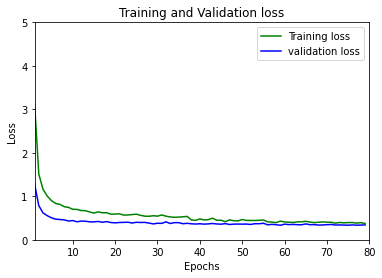

In [26]:
# train the model
time_list = []
all_losses = {'epoch': [],
              'train': [],
              'valid': []
             }
model_transfer = train(100, loaders_transfer, model_transfer_resnet50, optimizer_resnet50, scheduler_resnet50,
                       criterion_resnet50, device, 'model_transfer_resnet50.pt', 20)
plot(all_losses)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [27]:
test(loaders_transfer, model_transfer_resnet50, criterion_resnet50, device)

Test Loss: 0.349842


Test Accuracy: 89% (748/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [86]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
from scipy.special import softmax
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path, model_transfer, use_cuda):
    # load the image and return the predicted breed
    image = Image.open(img_path)
    # image.show()
    loader = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224), 
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                [0.229, 0.224, 0.225])])
    image = loader(image).float()
    image = image.unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
        out = model_transfer(image).cpu().data
    else:
        out = model_transfer(image).data
    return softmax(out.numpy()).reshape(-1), out.numpy().argmax() # predicted class label
    

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [90]:

### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def show_image_with_pie(img_path,title_picture,title_pie,likely_breeds,likely_probs):
    # Read the image
    print(img_path)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)  
    # Show the image
    if title_pie is None:
        fig, ax = plt.subplots(figsize=(12,4))  
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])       
        ax.set_title(title_picture)
    else:
        fig, ax = plt.subplots(1,2,figsize=(10,4))  
        ax[0].imshow(img)
        ax[0].set_xticks([])
        ax[0].set_yticks([])   
        ax[0].set_title(title_picture)
        wedges, texts, autotexts = ax[1].pie(likely_probs, 
                                             autopct='%1.1f%%', wedgeprops = {'linewidth': 0})
        ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax[1].legend(wedges, likely_breeds, title="Likely breeds",
                     loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))    
        ax[1].set_title(title_pie)
    plt.show()    
    
def process_probs(pred, probs, class_names, threshold = 0.01, max_n = 4):
    # Let's discard unlikely breeds
    selection = probs > threshold

    likely_breeds = [breed for (breed, detected) in zip(class_names, selection) if detected]
    likely_probs = [prob for (prob, detected) in zip(probs, selection) if detected]    

    order = np.argsort(np.array(likely_probs))[::-1]
    likely_breeds = [likely_breeds[int(i)] for i in order]
    likely_probs = [likely_probs[int(i)] for i in order]
    likely_breeds = likely_breeds[:max_n]
    likely_probs = likely_probs[:max_n]
    
    # And let's fill the discarded gap with "other" (if there is a gap)
    if len(likely_breeds) > 1:
        likely_breeds = likely_breeds + ["Other"]
        likely_probs = likely_probs + [1 - sum(likely_probs)]
    else:
        # If no other breed is predicted with at least 1% let's round up the confidence to 100% 
        likely_probs = [100]
        
    return likely_breeds, likely_probs

def run_app(img_path, model, model_transfer, class_names, use_cuda):
    ## handle cases for a human face, dog, and neither
    # Check if a dog is detected
    dog_detected = dog_detector(img_path, model)
    # Check if a human is detected
    human_detected = face_detector(img_path)
    # Get the predicted breed(s)
    probs, pred = predict_breed_transfer(img_path, model_transfer, use_cuda)
    
    # Process class probabilities (remove very low probabilities and replace with "other", sort them etc)
    likely_breeds, likely_probs = process_probs(pred, probs, class_names)
    # Decide on titles and such
    if dog_detected and not human_detected:
        title_picture = f"Who's a good doggie?\nThis {class_names[pred]} is!"
        if len(likely_breeds) == 1:
            title_pie = "A purebred!"
        else:
            title_pie = "Interesting mix we've got here..."
    elif not dog_detected and human_detected:
        title_picture = f"Hello there!\nYou look like a {class_names[pred]}!"
        title_pie = "Here are all the dog breeds you look like:"        
    elif dog_detected and human_detected:
        title_picture = f"Hello human, that's a nice {class_names[pred]} you've got there!"
        if len(likely_breeds) == 1:
            title_pie = "A purebred!"
        else:
            title_pie = "Interesting mix we've got here..."        
    else:
        title_picture = "That's a nice picture but I can't find any dogs or humans here..."
        title_pie = None
        
    # Show everything
    show_image_with_pie(img_path,title_picture,title_pie,likely_breeds,likely_probs)


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/lfw/Rachel_Griffiths/Rachel_Griffiths_0001.jpg


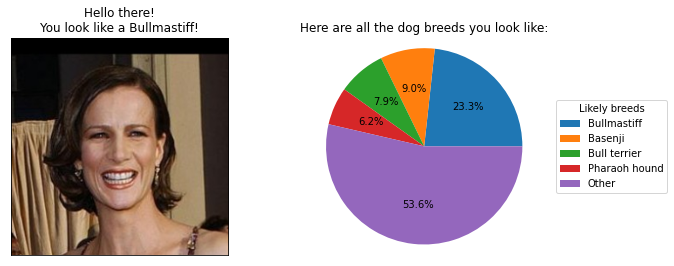

/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/lfw/Bryan_Cooley/Bryan_Cooley_0001.jpg


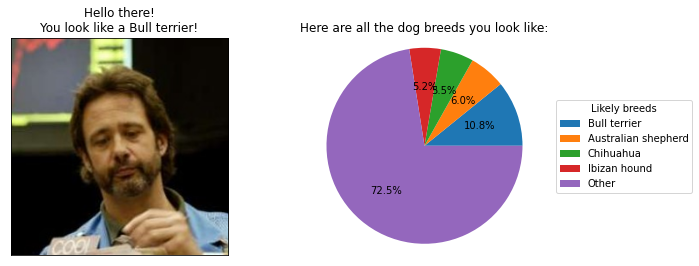

/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/lfw/Ralph_Klein/Ralph_Klein_0001.jpg


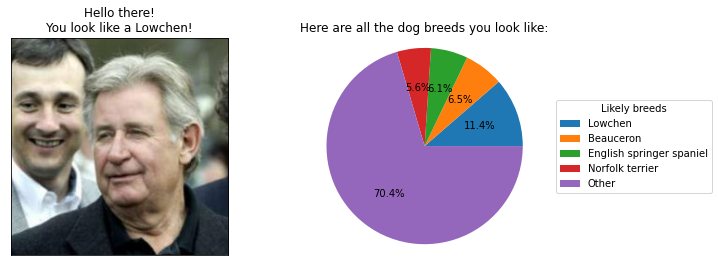

/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/lfw/Joseph_Deiss/Joseph_Deiss_0001.jpg


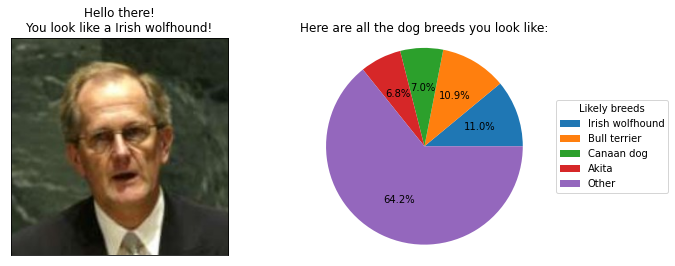

/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/lfw/Monica_Lewinsky/Monica_Lewinsky_0003.jpg


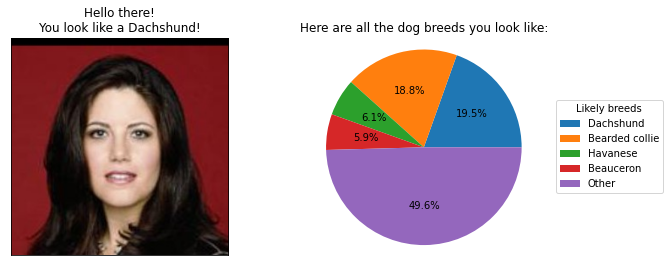

/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/dogImages/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00618.jpg


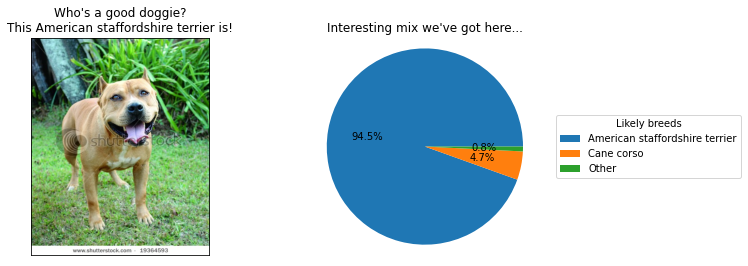

/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/dogImages/valid/004.Akita/Akita_00237.jpg


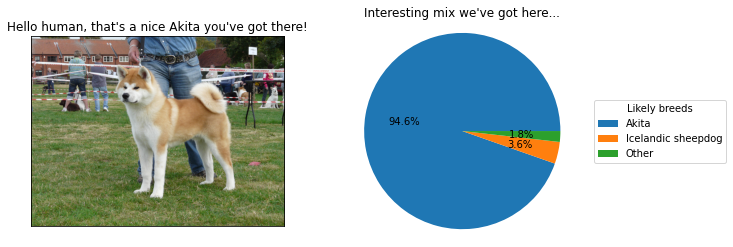

/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/dogImages/train/097.Lakeland_terrier/Lakeland_terrier_06501.jpg


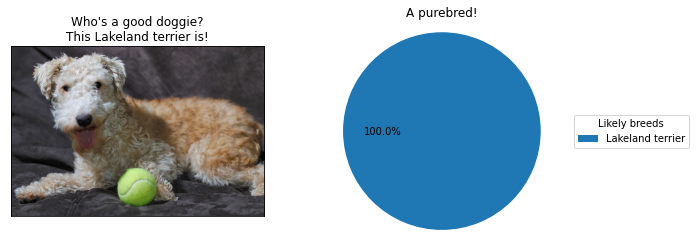

/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/dogImages/train/024.Bichon_frise/Bichon_frise_01716.jpg


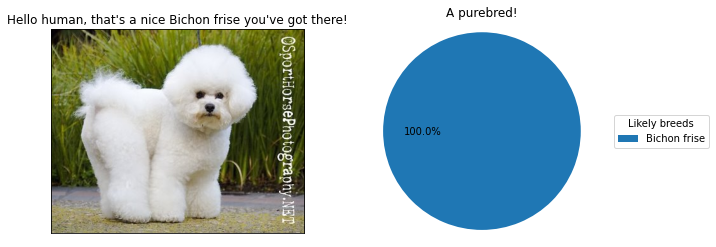

/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/dogImages/train/078.Great_dane/Great_dane_05361.jpg


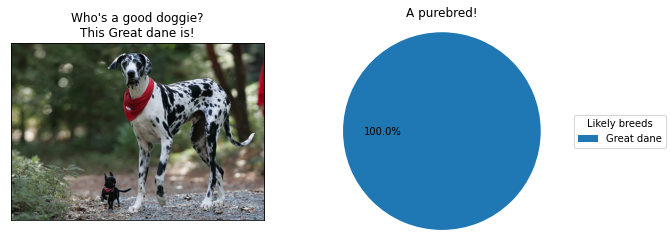

In [91]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
model = VGG16_bn
model_transfer = model_transfer_resnet50
## suggested code, below
selection_human = np.random.randint(0,high=len(human_files),size=5)
selection_dogs = np.random.randint(0,high=len(dog_files),size=5)
for file in np.hstack((human_files[selection_human], dog_files[selection_dogs])):
    run_app(file, model, model_transfer, class_names, use_cuda)